In [1]:
import jax.numpy as jnp
from jax import jit,grad,hessian,jacfwd,jacrev,vmap
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from jax.scipy.linalg import block_diag
from jax.scipy.linalg import solve

from scipy.interpolate import RectBivariateSpline

/home/juanfelipe/anaconda3/envs/jaxenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [99]:
#u_data = jnp.load("darcy_example_data/u_vals.npy")
x_grid=jnp.linspace(0,1,100)
y_grid=jnp.linspace(0,1,100)
X,Y=jnp.meshgrid(x_grid,y_grid)

@jit
def u_true_function1(x1,x2):
    return jnp.exp(jnp.sin(1*(jnp.cos(2*x1) + jnp.cos(3*x2))))

def u_true_function2(x1,x2):
    return jnp.exp(0.2 * (jnp.sin(1*(jnp.cos(5*x1) - jnp.cos(4*x2)))))

def u_true_function3(x1,x2):
    return jnp.sin(2 * x1) * jnp.cos(3 * x2)

def A(x1,x2):
    return jnp.exp(jnp.sin(jnp.cos(x1) + jnp.cos(x2)))
    #return 2.

def A_times_grad_u1(x1,x2):
    grad_u = jacfwd(u_true_function1, argnums=[0,1])
    return A(x1,x2)*jnp.array(grad_u(x1,x2))
def A_times_grad_u2(x1,x2):
    grad_u = jacfwd(u_true_function2, argnums=[0,1])
    return A(x1,x2)*jnp.array(grad_u(x1,x2))
def A_times_grad_u3(x1,x2):
    grad_u = jacfwd(u_true_function3, argnums=[0,1])
    return A(x1,x2)*jnp.array(grad_u(x1,x2))

def rhs1(x1,x2):
    div = jacfwd(A_times_grad_u1, argnums=[0,1])
    return -jnp.trace(jnp.array(div(x1,x2)))
def eval_rhs1(pairs):
    return jnp.array(vmap(lambda t: rhs1(t[0], t[1]))(pairs))

def rhs2(x1,x2):
    div = jacfwd(A_times_grad_u2, argnums=[0,1])
    return -jnp.trace(jnp.array(div(x1,x2)))
def eval_rhs2(pairs):
    return jnp.array(vmap(lambda t: rhs2(t[0], t[1]))(pairs))

def rhs3(x1,x2):
    div = jacfwd(A_times_grad_u3, argnums=[0,1])
    return -jnp.trace(jnp.array(div(x1,x2)))
def eval_rhs3(pairs):
    return jnp.array(vmap(lambda t: rhs3(t[0], t[1]))(pairs))

In [100]:
def build_xy_grid(x_range,y_range,num_grid_x,num_grid_y):
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    full_y_grid = jnp.linspace(y_range[0],y_range[1],num_grid_y)


    x_interior = full_x_grid[1:-1]
    y_interior = full_y_grid[1:-1]
    
    x_boundary = full_x_grid[jnp.array([0,-1])]
    y_boundary = full_y_grid[jnp.array([0,-1])]

    #Get interior points
    x,y = jnp.meshgrid(x_interior,y_interior)
    xy_interior = jnp.vstack([x.flatten(),y.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    x,y = jnp.meshgrid(x_interior,y_boundary)
    xy_boundary_1 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_interior)
    xy_boundary_2 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_boundary)
    xy_boundary_3 = jnp.vstack([x.flatten(),y.flatten()]).T

    xy_boundary = jnp.vstack([xy_boundary_1,xy_boundary_2,xy_boundary_3])
    return xy_interior,xy_boundary

In [101]:
num_grid_points = 17
# Ghost grid - Same per function
xy_int,xy_bdy = build_xy_grid([0,1],[0,1],num_grid_points,num_grid_points)
xy_all = jnp.vstack([xy_bdy,xy_int])


u_true1 = u_true_function1(xy_all[:,0],xy_all[:,1])
u_true2 = u_true_function2(xy_all[:,0],xy_all[:,1])
u_true3 = u_true_function3(xy_all[:,0],xy_all[:,1])


num_obs1 = 10
np.random.seed(20)
x_y_sample_inds1 = np.random.choice(list(np.arange(len(xy_int))),num_obs1,replace = False)
x_y_sample_inds1 = jnp.hstack([x_y_sample_inds1])
xy_obs1 = jnp.vstack([xy_bdy,xy_int[x_y_sample_inds1]])
u_obs1 = u_true_function1(xy_obs1[:,0],xy_obs1[:,1])

num_obs2 = 10
np.random.seed(21)
x_y_sample_inds2 = np.random.choice(list(np.arange(len(xy_int))),num_obs2,replace = False)
x_y_sample_inds2 = jnp.hstack([x_y_sample_inds2])
xy_obs2 = jnp.vstack([xy_bdy,xy_int[x_y_sample_inds2]])
u_obs2 = u_true_function2(xy_obs2[:,0],xy_obs2[:,1])

num_obs3 = 10
np.random.seed(22)
x_y_sample_inds3 = np.random.choice(list(np.arange(len(xy_int))),num_obs3,replace = False)
x_y_sample_inds3 = jnp.hstack([x_y_sample_inds3])
xy_obs3 = jnp.vstack([xy_bdy,xy_int[x_y_sample_inds3]])
u_obs3 = u_true_function3(xy_obs3[:,0],xy_obs3[:,1])

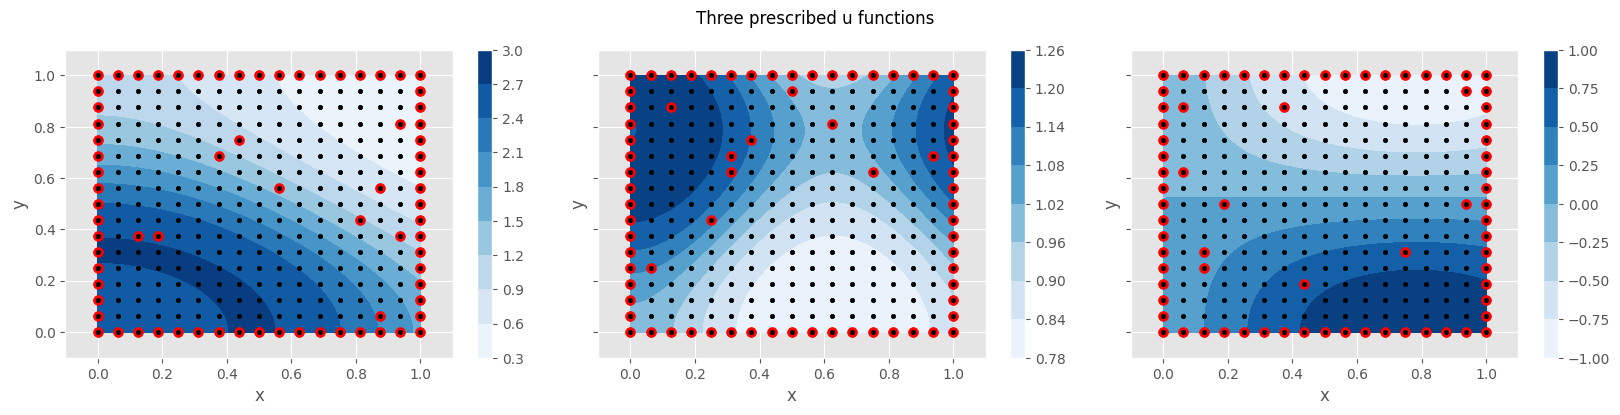

In [102]:
# Plot u's
num_fine_grid = 100
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
xy_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T


fig, axs = plt.subplots(figsize = (20,4), nrows =1 , ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Three prescribed u functions')
axs0 = axs[0].tricontourf(xy_fine[:,0],xy_fine[:,1],u_true_function1(xy_fine[:,0],xy_fine[:,1]),cmap = 'Blues')
plt.colorbar(axs0, ax = axs[0])
axs[0].scatter(xy_obs1[:,0],xy_obs1[:,1],c='red', s = 50)
axs[0].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_xlim(-0.1,1.1)
axs[0].set_ylim(-0.1,1.1)
axs1 = axs[1].tricontourf(xy_fine[:,0],xy_fine[:,1],u_true_function2(xy_fine[:,0],xy_fine[:,1]),cmap = 'Blues')
plt.colorbar(axs1, ax = axs[1])
axs[1].scatter(xy_obs2[:,0],xy_obs2[:,1],c='red', s = 50)
axs[1].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_xlim(-0.1,1.1)
axs[1].set_ylim(-0.1,1.1)
axs2 = axs[2].tricontourf(xy_fine[:,0],xy_fine[:,1],u_true_function3(xy_fine[:,0],xy_fine[:,1]),cmap = 'Blues')
plt.colorbar(axs2, ax = axs[2])
axs[2].scatter(xy_obs3[:,0],xy_obs3[:,1],c='red', s = 50)
axs[2].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_xlim(-0.1,1.1)
axs[2].set_ylim(-0.1,1.1)
plt.show()

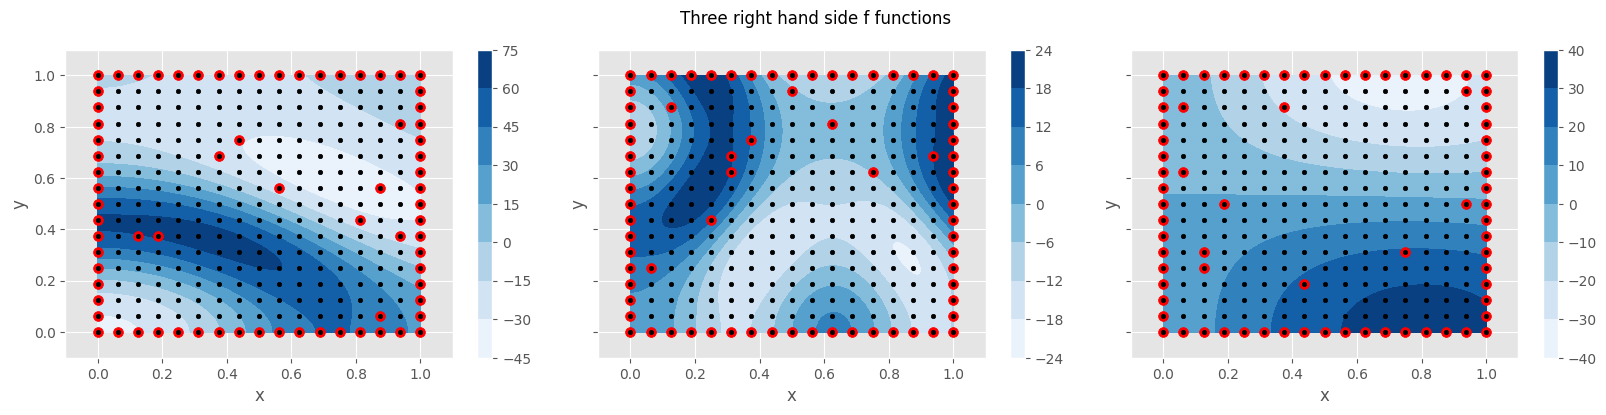

In [103]:
# Plot f's
num_fine_grid = 100
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
xy_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

fig, axs = plt.subplots(figsize = (20,4), nrows =1 , ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Three right hand side f functions')
axs0 = axs[0].tricontourf(xy_fine[:,0],xy_fine[:,1],eval_rhs1(xy_fine),cmap = 'Blues')
plt.colorbar(axs0, ax = axs[0])
axs[0].scatter(xy_obs1[:,0],xy_obs1[:,1],c='red', s = 50)
axs[0].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_xlim(-0.1,1.1)
axs[0].set_ylim(-0.1,1.1)
axs1 = axs[1].tricontourf(xy_fine[:,0],xy_fine[:,1],eval_rhs2(xy_fine),cmap = 'Blues')
plt.colorbar(axs1, ax = axs[1])
axs[1].scatter(xy_obs2[:,0],xy_obs2[:,1],c='red', s = 50)
axs[1].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_xlim(-0.1,1.1)
axs[1].set_ylim(-0.1,1.1)
axs2 = axs[2].tricontourf(xy_fine[:,0],xy_fine[:,1],eval_rhs3(xy_fine),cmap = 'Blues')
plt.colorbar(axs2, ax = axs[2])
axs[2].scatter(xy_obs3[:,0],xy_obs3[:,1],c='red', s = 50)
axs[2].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_xlim(-0.1,1.1)
axs[2].set_ylim(-0.1,1.1)
plt.show()

In [104]:
# Concatenate everything
xy_obs = np.vstack([xy_obs1, xy_obs2, xy_obs3])
u_obs = np.concatenate([u_obs1, u_obs2, u_obs3])

In [105]:
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = [eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op]


k_u = get_gaussianRBF(0.1)#get_sum_of_kernels([get_gaussianRBF(0.05),get_gaussianRBF(0.2)],coefficients=[0.5,0.5])#get_gaussianRBF(0.1)

u1_model = InducedRKHS(
    xy_all,
    feature_operators,
    k_u
    )

u2_model = InducedRKHS(
    xy_all,
    feature_operators,
    k_u
    )

u3_model = InducedRKHS(
    xy_all,
    feature_operators,
    k_u
    )

u1_params_init = u1_model.get_fitted_params(xy_obs1,u_obs1)

u2_params_init = u2_model.get_fitted_params(xy_obs2,u_obs2)

u3_params_init = u3_model.get_fitted_params(xy_obs3,u_obs3)

grid_features_u1_init = (
    (u1_model.evaluate_operators(feature_operators,xy_int,u1_params_init))
    .reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        )
)

grid_features_u2_init = (
    (u2_model.evaluate_operators(feature_operators,xy_int,u2_params_init))
    .reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        )
)

grid_features_u3_init = (
    (u3_model.evaluate_operators(feature_operators,xy_int,u3_params_init))
    .reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        )
)

grid_features_u_init = jnp.vstack([grid_features_u1_init, grid_features_u2_init, grid_features_u3_init])

k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init,c=1)
k_P_x_part = get_gaussianRBF(0.1)

def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
 

class P_model():
    kernel_function = jit(
        get_kernel_block_ops(k_P,[eval_k],[eval_k])
    )

    @jit
    def predict(input_data,params):
        K = P_model.kernel_function(input_data,input_data)
        return K@params

ind1 = u1_model.num_params
ind2 = ind1 + u1_model.num_params

def split_u_params(u_params):
    u_params1 = u_params[:ind1]
    u_params2 = u_params[ind1:ind2]
    u_params3 = u_params[ind2:]
    return u_params1, u_params2, u_params3

class EqnModel():
    datafit_weight = 40

    @jit
    def get_grid_features(u_params):
        u_params1, u_params2, u_params3 = split_u_params(u_params)
        evaluation_u1 = u1_model.evaluate_operators(feature_operators,xy_int,u_params1)
        evaluation_u2 = u2_model.evaluate_operators(feature_operators,xy_int,u_params2)
        evaluation_u3 = u3_model.evaluate_operators(feature_operators,xy_int,u_params3)
        grid_features_u1 = evaluation_u1.reshape(len(xy_int),len(feature_operators),order = 'F')
        grid_features_u2 = evaluation_u2.reshape(len(xy_int),len(feature_operators),order = 'F')
        grid_features_u3 = evaluation_u3.reshape(len(xy_int),len(feature_operators),order = 'F')
        grid_features_u = jnp.vstack([grid_features_u1, grid_features_u2, grid_features_u3])
        full_features = jnp.hstack([jnp.tile(xy_int.T,3).T,grid_features_u])
        return full_features
    
    @jit
    def get_grid_target(u_params):
        #return jnp.ones(len(xy_int))
        return jnp.concatenate([eval_rhs1(xy_int), eval_rhs2(xy_int), eval_rhs3(xy_int)])
    
    @jit
    def eval_obs_points(u_params):
        u_params1, u_params2, u_params3 = split_u_params(u_params)
        return jnp.concatenate([u1_model.point_evaluate(xy_obs1,u_params1),
                               u2_model.point_evaluate(xy_obs2,u_params2),
                               u3_model.point_evaluate(xy_obs3,u_params3)])
    
    @jit
    def datafit_residual(u_params):
        obs_preds = EqnModel.eval_obs_points(u_params)
        return u_obs - obs_preds
    
    @jit
    def equation_residual(full_params):
        u_model_num_params = u1_model.num_params + u2_model.num_params + u3_model.num_params
        u_params = full_params[:u_model_num_params]
        P_params = full_params[u_model_num_params:]
        P_features = EqnModel.get_grid_features(u_params)
        P_model_preds = P_model.predict(P_features,P_params)
        ugrid_target = EqnModel.get_grid_target(u_params)
        return (ugrid_target - P_model_preds)
    
    @jit
    def F(full_params):
        u_model_num_params = u1_model.num_params + u2_model.num_params + u3_model.num_params
        u_params = full_params[:u_model_num_params]
        eqn_res = EqnModel.equation_residual(full_params)
        data_res = EqnModel.datafit_residual(u_params)
        return jnp.hstack([
            EqnModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
            eqn_res/jnp.sqrt(len(eqn_res))
            ])
    
    jac = jit(jacrev(F))

    def loss(full_params):
        return jnp.linalg.norm(EqnModel.F(full_params))**2
    
    @jit
    def damping_matrix(full_params):
        u_model_num_params = u1_model.num_params + u2_model.num_params + u3_model.num_params
        u_params = full_params[:u_model_num_params]
        grid_feats = EqnModel.get_grid_features(u_params)
        kmat_P = P_model.kernel_function(grid_feats,grid_feats)
        dmat = block_diag(
            u1_model.kmat+1e-3 * diagpart(u1_model.kmat),
            u2_model.kmat+1e-3 * diagpart(u2_model.kmat),
            u3_model.kmat+1e-3 * diagpart(u3_model.kmat),
            1e-3 * (kmat_P+1e-3 * jnp.identity(len(kmat_P)))
        )
        return dmat

In [106]:
u_params_init = jnp.concatenate([u1_params_init,u2_params_init,u3_params_init])

In [107]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize
params_init = jnp.hstack([u_params_init,jnp.zeros(3*len(xy_int))])

params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-8,
    max_iter = 1001,
    init_alpha=3,
    line_search_increase_ratio=2.
)

  0%|          | 2/1001 [00:00<02:34,  6.45it/s]

Iteration 0, loss = 3.675, Jres = 354.7, alpha = 2.727
Iteration 1, loss = 1.742, Jres = 4.793e+03, alpha = 2.727


  0%|          | 4/1001 [00:00<02:30,  6.61it/s]

Iteration 2, loss = 0.3429, Jres = 2.654e+04, alpha = 2.479
Iteration 3, loss = 0.2201, Jres = 6.948e+03, alpha = 2.254


  1%|          | 6/1001 [00:00<02:29,  6.66it/s]

Iteration 4, loss = 0.1576, Jres = 5.095e+03, alpha = 2.049
Iteration 5, loss = 0.1215, Jres = 3.147e+03, alpha = 1.863


  5%|▌         | 52/1001 [00:07<02:21,  6.71it/s]

Iteration 50, loss = 0.001073, Jres = 125.8, alpha = 0.03401


 10%|█         | 102/1001 [00:15<02:13,  6.72it/s]

Iteration 100, loss = 0.0001477, Jres = 46.74, alpha = 0.008957


 15%|█▌        | 152/1001 [00:22<02:06,  6.71it/s]

Iteration 150, loss = 6.396e-05, Jres = 4.714, alpha = 0.008957


 20%|██        | 202/1001 [00:30<01:59,  6.70it/s]

Iteration 200, loss = 4.395e-05, Jres = 1.51, alpha = 0.008957


 25%|██▌       | 252/1001 [00:37<01:51,  6.71it/s]

Iteration 250, loss = 3.431e-05, Jres = 0.8346, alpha = 0.008957


 27%|██▋       | 273/1001 [00:41<01:51,  6.53it/s]

Line Search Failed!
Final Iteration Results
Iteration 273, loss = 3.169e-05, Jres = 0.1914, alpha = 2.436e+04


In [ ]:
hess_loss = jit(jax.hessian(EqnModel.loss))
gradloss = jit(jax.grad(EqnModel.loss))

#H = hess_loss(params)
#g = gradloss(params)

#analyze_hessian(H,g)

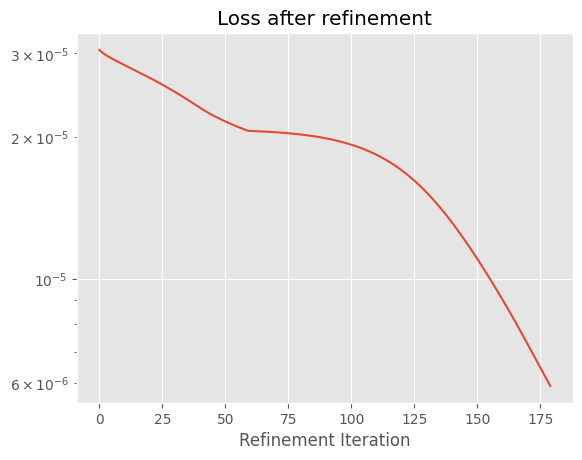

In [119]:
from LM_Solve import refine_solution

reg_sequence = jnp.hstack([
    10**(jnp.arange(-3.,-4,-0.025)),
    jnp.array(20*[10**(-4)]),
    10**(jnp.arange(-3.,-6,-0.025))
    ])

p_adjusted,refinement_losses = refine_solution(params,EqnModel,reg_sequence = reg_sequence)

plt.plot(refinement_losses)
plt.xlabel("Refinement Iteration")
plt.title("Loss after refinement")
plt.yscale('log')

In [ ]:
#analyze_hessian(hess_loss(p_adjusted),gradloss(p_adjusted))

In [120]:
u_model_num_params = u1_model.num_params + u2_model.num_params + u3_model.num_params
u1_sol = p_adjusted[:u1_model.num_params]
u2_sol = p_adjusted[u1_model.num_params:u1_model.num_params+u2_model.num_params]
u3_sol = p_adjusted[
    u1_model.num_params+u2_model.num_params:
    u1_model.num_params+u2_model.num_params+u3_model.num_params]
P_sol = p_adjusted[u_model_num_params:]
#params
u_sol = p_adjusted[:u_model_num_params]
# P_sol = params[u_model.num_params:]


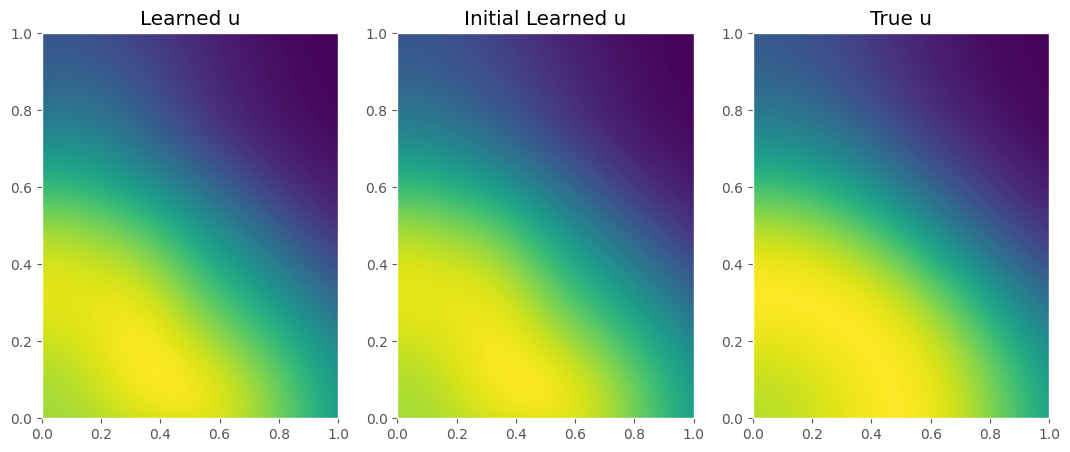

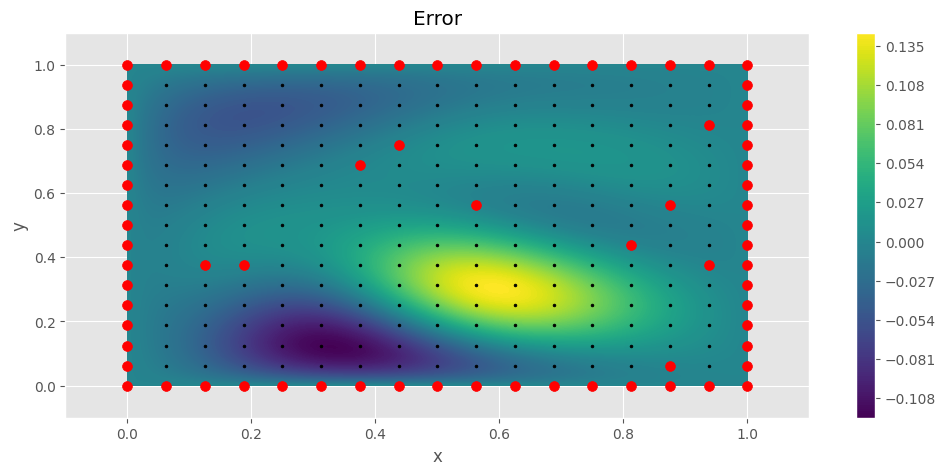

In [121]:
num_fine_grid = 100
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
xy_grid_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T


u_eval_fine =u1_model.point_evaluate(xy_grid_fine,u1_sol)
u_eval_fine_init = u1_model.point_evaluate(xy_grid_fine,u1_params_init)

u_true_fine = u_true_function1(xy_grid_fine[:,0],xy_grid_fine[:,1])
plt.figure(figsize=(13,5))
plt.subplot(1,3,1)
plt.title("Learned u")
plt.tricontourf(xy_grid_fine[:,0],xy_grid_fine[:,1],u_eval_fine,200)

plt.subplot(1,3,2)
plt.title("Initial Learned u")
plt.tricontourf(xy_grid_fine[:,0],xy_grid_fine[:,1],u_eval_fine_init,200)

plt.subplot(1,3,3)
plt.title("True u")
plt.tricontourf(xy_grid_fine[:,0],xy_grid_fine[:,1],u_true_fine,200)
plt.show()
plt.figure(figsize = (12,5))
plt.title("Error")
plt.tricontourf(xy_grid_fine[:,0],xy_grid_fine[:,1],u_true_fine-u_eval_fine,250)
plt.colorbar()
plt.scatter(xy_all[:,0],xy_all[:,1],c='black',s = 4)
plt.scatter(xy_obs1[:,0],xy_obs1[:,1],c='red',s = 50)

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

In [122]:
print(jnp.mean((u_true_fine-u_eval_fine)**2)/jnp.mean(u_true_fine**2))
print(jnp.mean((u_true_fine-u_eval_fine_init)**2)/jnp.mean(u_true_fine**2))

0.0005021712166581525
0.00041246615355390885


In [123]:
u_eval_fine =u2_model.point_evaluate(xy_grid_fine,u2_sol)
u_eval_fine_init = u2_model.point_evaluate(xy_grid_fine,u2_params_init)

u_true_fine = u_true_function2(xy_grid_fine[:,0],xy_grid_fine[:,1])

print(jnp.mean((u_true_fine-u_eval_fine)**2)/jnp.mean(u_true_fine**2))
print(jnp.mean((u_true_fine-u_eval_fine_init)**2)/jnp.mean(u_true_fine**2))

0.0003041461502394509
0.0010520310754504744


In [124]:
u_eval_fine =u3_model.point_evaluate(xy_grid_fine,u3_sol)
u_eval_fine_init = u3_model.point_evaluate(xy_grid_fine,u3_params_init)

u_true_fine = u_true_function3(xy_grid_fine[:,0],xy_grid_fine[:,1])

print(jnp.mean((u_true_fine-u_eval_fine)**2)/jnp.mean(u_true_fine**2))
print(jnp.mean((u_true_fine-u_eval_fine_init)**2)/jnp.mean(u_true_fine**2))

0.000781113975023538
0.002042453462883253


In [125]:
num_fine_grid = 50
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

u_true_interior = u_true_function1(xy_fine_int[:,0],xy_fine_int[:,1])

model_grid_features_all = EqnModel.get_grid_features(u_sol)


model_fine_features_u = u1_model.evaluate_operators(feature_operators,xy_fine_int,u1_sol).reshape(len(xy_fine_int),len(feature_operators),order = 'F')
evaluation_u = u1_model.evaluate_operators(feature_operators,xy_fine_int,u1_sol)
grid_features_u = evaluation_u.reshape(len(xy_fine_int),len(feature_operators),order = 'F')
model_fine_features = jnp.hstack([xy_fine_int,grid_features_u])


P_preds_model_features = P_model.kernel_function(model_fine_features,model_grid_features_all)@P_sol

init_P_features = EqnModel.get_grid_features(u_params_init)

K = P_model.kernel_function(init_P_features,init_P_features)

P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.get_grid_target(u_params_init))

init_fine_features_u = u1_model.evaluate_operators(feature_operators,xy_fine_int,u1_params_init).reshape(len(xy_fine_int),len(feature_operators),order = 'F')
evaluation_u = u1_model.evaluate_operators(feature_operators,xy_fine_int,u1_sol)
grid_features_u = evaluation_u.reshape(len(xy_fine_int),len(feature_operators),order = 'F')
init_fine_features = jnp.hstack([xy_fine_int,grid_features_u])

P_preds_init_model_features_init = P_model.kernel_function(init_fine_features,init_P_features)@P_params_naive

In [126]:
def get_nrmse(true,pred):
    return jnp.sqrt(jnp.mean((true-pred)**2)/jnp.mean(true**2))

print("Optimized model feature predictions ",get_nrmse(eval_rhs1(xy_fine_int),P_preds_model_features))
print("2 Step model feature predictions ",get_nrmse(eval_rhs1(xy_fine_int),P_preds_init_model_features_init))

Optimized model feature predictions  0.0009603898485735288
2 Step model feature predictions  0.08323091840595895


In [ ]:
plt.tricontourf(xy_fine_int[:,0],xy_fine_int[:,1],eval_rhs1(xy_fine_int)-P_preds_model_features)
plt.colorbar()
plt.show()
plt.tricontourf(xy_fine_int[:,0],xy_fine_int[:,1],eval_rhs1(xy_fine_int)-P_preds_init_model_features_init)
plt.colorbar()
plt.show()


In [ ]:
sigma_perm = 0.3
def g_perm(x1,x2):
    return jnp.exp(-((x1 - 0.4)**2 + (x2 - 0.5)**2)/(2*sigma_perm**2))
def permeability_function(x):
    return 1.3 - g_perm(x[0],x[1])

def P(x,y,u):
    def inside(stuff):
        return permeability_function(jnp.array([stuff[0],stuff[1]])) * grad(u)(jnp.array([stuff[0],stuff[1]]))
    return jnp.trace(jacrev(inside)(jnp.array([x,y])))

In [ ]:
def u_example(x):
    return jnp.sin(x[0] + x[1])

def u_example_fake(x,y):
    return jnp.sin(x[0] + x[1])


def Pfunc(x):
    return P(x[0],x[1],u_example)

Pvec = jax.vmap(Pfunc)

truth = Pvec(xy_int)

In [ ]:
@jit
def evaluate_function_features(x):
    return [op(u_example_fake,0)(jnp.array([x[0],x[1]]),jnp.array([0,0])) for op in feature_operators]

vec_eval = jax.vmap(evaluate_function_features)

In [ ]:
test_features_u = jnp.array(vec_eval(xy_int)).T
test_features = jnp.hstack([xy_int,test_features_u])

In [ ]:
get_nrmse(truth,P_model.predict(test_features,P_sol))

In [ ]:
get_nrmse(truth,P_model.predict(test_features,P_params_naive))

In [ ]:
plt.tricontourf(xy_fine[:,0],xy_fine[:,1],permeability_function(xy_fine[:,0],xy_fine[:,1]))
plt.colorbar()